#Imports

In [109]:
import torch
import torchvision
import matplotlib
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

#Data exploration

In [110]:
wine_data = pd.read_csv('csv/winequality-red.csv', delimiter= ';')
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [111]:
wine_data.shape

(1599, 12)

In [112]:
X_cols = list(wine_data.columns)[:-1] #feature variables
Y_cols  = ['quality'] #Target variable to be predicted

In [113]:
wine_data1 = wine_data.copy(deep=True) #Copy of original dataframe
X_arrays = wine_data1[X_cols].to_numpy() #Converting numerical variables to numpy arrays
Y_arrays = wine_data1[Y_cols].to_numpy() #Converting target variable to numpy arrays

X_arrays, Y_arrays

(array([[ 7.4  ,  0.7  ,  0.   , ...,  3.51 ,  0.56 ,  9.4  ],
        [ 7.8  ,  0.88 ,  0.   , ...,  3.2  ,  0.68 ,  9.8  ],
        [ 7.8  ,  0.76 ,  0.04 , ...,  3.26 ,  0.65 ,  9.8  ],
        ...,
        [ 6.3  ,  0.51 ,  0.13 , ...,  3.42 ,  0.75 , 11.   ],
        [ 5.9  ,  0.645,  0.12 , ...,  3.57 ,  0.71 , 10.2  ],
        [ 6.   ,  0.31 ,  0.47 , ...,  3.39 ,  0.66 , 11.   ]]),
 array([[5],
        [5],
        [5],
        ...,
        [6],
        [5],
        [6]], dtype=int64))

In [114]:
X = torch.from_numpy(X_arrays).type(torch.float) #Converting numpy arrays to torch tensors
Y = torch.from_numpy(Y_arrays).type(torch.float)
print(X.shape, Y.shape)
X, Y

torch.Size([1599, 11]) torch.Size([1599, 1])


(tensor([[ 7.4000,  0.7000,  0.0000,  ...,  3.5100,  0.5600,  9.4000],
         [ 7.8000,  0.8800,  0.0000,  ...,  3.2000,  0.6800,  9.8000],
         [ 7.8000,  0.7600,  0.0400,  ...,  3.2600,  0.6500,  9.8000],
         ...,
         [ 6.3000,  0.5100,  0.1300,  ...,  3.4200,  0.7500, 11.0000],
         [ 5.9000,  0.6450,  0.1200,  ...,  3.5700,  0.7100, 10.2000],
         [ 6.0000,  0.3100,  0.4700,  ...,  3.3900,  0.6600, 11.0000]]),
 tensor([[5.],
         [5.],
         [5.],
         ...,
         [6.],
         [5.],
         [6.]]))

In [115]:
dataset = TensorDataset(X, Y)
dataset1 = TensorDataset(X, Y)

train_set, val_set = random_split(dataset, [1300, 299])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)
test_loader = DataLoader(dataset1)

#Linear Model

In [116]:
class QualityModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(11,1) #11 input features, 1 output target variable

    def forward(self, x):
        x = self.linear(x)
        return x
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)         
        # Calcuate loss from mean squared error
        loss_fn = nn.MSELoss()
        loss = loss_fn(out, targets)                      
        return loss

    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)         
        # Calcuate loss from mean squared error
        loss_fn = nn.MSELoss()
        loss = loss_fn(out, targets)                        
        return {'val_loss': loss.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 100th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

#Initializing the model
model = QualityModel()


#Training and Validation phase with the help of pre-defined user functions

In [117]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, optimizer=torch.optim.SGD):
    history = []
    optimizer = optimizer(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [118]:
epochs = 2000
lr = 1e-6
history = fit(epochs, lr, model, train_loader, val_loader)

Epoch [100], val_loss: 17.9032
Epoch [200], val_loss: 10.1999
Epoch [300], val_loss: 6.0786
Epoch [400], val_loss: 3.8252
Epoch [500], val_loss: 2.5522
Epoch [600], val_loss: 1.8115
Epoch [700], val_loss: 1.3721
Epoch [800], val_loss: 1.1039
Epoch [900], val_loss: 0.9389
Epoch [1000], val_loss: 0.8364
Epoch [1100], val_loss: 0.7724
Epoch [1200], val_loss: 0.7324
Epoch [1300], val_loss: 0.7078
Epoch [1400], val_loss: 0.6931
Epoch [1500], val_loss: 0.6844
Epoch [1600], val_loss: 0.6796
Epoch [1700], val_loss: 0.6771
Epoch [1800], val_loss: 0.6761
Epoch [1900], val_loss: 0.6758
Epoch [2000], val_loss: 0.6759


Text(0, 0.5, 'Validation loss')

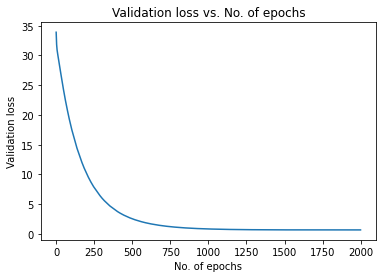

In [119]:
plt.title('Validation loss vs. No. of epochs');
loss_mat = [res['val_loss'] for res in history]
plt.plot(loss_mat)
plt.xlabel('No. of epochs')
plt.ylabel('Validation loss')

In [120]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [121]:
for i in range(5):
    input, target = val_set[i]
    predict_single(input, target, model)

Input: tensor([ 9.3000,  0.7750,  0.2700,  2.8000,  0.0780, 24.0000, 56.0000,  0.9984,
         3.3100,  0.6700, 10.6000])
Target: tensor([6.])
Prediction: tensor([6.0149])
Input: tensor([10.5000,  0.3600,  0.4700,  2.2000,  0.0740,  9.0000, 23.0000,  0.9964,
         3.2300,  0.7600, 12.0000])
Target: tensor([6.])
Prediction: tensor([6.4500])
Input: tensor([7.0000e+00, 9.7500e-01, 4.0000e-02, 2.0000e+00, 8.7000e-02, 1.2000e+01,
        6.7000e+01, 9.9565e-01, 3.3500e+00, 6.0000e-01, 9.4000e+00])
Target: tensor([4.])
Prediction: tensor([5.0060])
Input: tensor([7.5000e+00, 5.1000e-01, 2.0000e-02, 1.7000e+00, 8.4000e-02, 1.3000e+01,
        3.1000e+01, 9.9538e-01, 3.3600e+00, 5.4000e-01, 1.0500e+01])
Target: tensor([6.])
Prediction: tensor([5.4819])
Input: tensor([ 7.2000,  0.6950,  0.1300,  2.0000,  0.0760, 12.0000, 20.0000,  0.9955,
         3.2900,  0.5400, 10.1000])
Target: tensor([5.])
Prediction: tensor([5.3577])
